> # Evaluating the Use of the Random Forest Classifier and <br> Logistic Regression to Classify Downgraded Credit and Debit  Transactions

> # Business Problem: 

> The Electronic Interchange Reimbursement Fee (EIRF) is a preventable downgrade category that's not being regularly monitored at the transactional level. Currently, the only indication that this fee is occuring is if and only if a partner acquiring bank provides our organization with an explicit invoice record.Currently, there is only one acquiring partner that is provinding this information in detail. This means tracking and invoicing of this fee is not being completely addressed by our business. This is a problem, because the current situiation creates the more than likely scenario that preventable costs are not being identified and mitigated.


> # Hypothesis: 

> The Electronic Interchange Reimbursement Fee (EIRF) is a preventable downgrade category that's not being regularly monitored at the transactional level. 
>Currently, the only indication that this fee is occuring is if and only if a partner acquiring bank provides our organization with an explicit invoice record. 
>Currently,there is only one acuiring partner that is provinding this information in detail. 
>This means tracking and invoicing of this fee is not being completely addressed by our business. 
This is a problem, because the current situiation creates the more than likely scenario that preventable costs are not being identified and mitigated.


> # What is a Downgrade

> "Each time a credit (or signature debit) card is processed...Every transaction has a target interchange category, which is the category that has the lowest rate and fee for the given transaction type.

> A downgrade occurs when a transaction is routed to an interchange category that is priced higher than the target category."

> source: https://www.cardfellow.com/credit-card-processing-downgrades/


> # What is EIRF

> "EIRF is a Visa (US) interchange category that indicates a downgrade. Transactions qualify for EIRF when they don't meet the criteria for categories with lower rates."

> source: https://www.cardfellow.com/visa-interchange-fees/eirf/
> imagesource: https://www.accenture.com/us-en/success-visa-connected-commerce-car



> # Why does it Matter

>Each time a downgrade occurs it's an additional cost to the business. These ocurrences allow for unecessary margin erosion since EIRF downgrades are largely preventable.

> Example:

>- EIRF Interchange rate & fee: 2.30% + 0.10
>- Regulated Debit Interchange rate & fee: 0.05 + 0.22

> Hypothetical:

>A transaction amount of 500.00 subject to EIRF would
>result in a 11.60 fee. While a transacation of the same 
>amount subject to a regulated debit would be subject to a 0.47 fee, a difference in cost by roughly 24x.

## Link to Pertient Libraries and Database

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
%matplotlib inline
from matplotlib import pyplot as plt

import pyodbc #CONNECT VIA PYODBC IMPORT THE PYODBC LIBRARY
print pyodbc.dataSources() #DISPLAY THE LISTED DATA SOURCES ON MACHINE, IN MY CASE I USE NETEZZASQL

{'ECL_CODA11': 'Oracle in instantclient_11_2', 'NZSQL': 'NetezzaSQL', 'IST_CODA11': 'Oracle in instantclient_11_2', 'BO_Lookup': 'Oracle in instantclient_11_2', 'Excel Files': 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'dBASE Files': 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)', 'MS Access Database': 'Microsoft Access Driver (*.mdb, *.accdb)'}


C:\Users\djohnson\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


># Data Extraction and Munging

>- All data was procured from the organization's BI database - mainted in a Neteeza data warehouse;

>- Information was run for a 3 month period (August-17 thru November-17);

>- Primary dataset is the credit card online database, a live dataset updated daily of all online transactions;

>- Information was parsed to only select transactions that settled, since these would be the only transactions subject to EIRF;

>- The Primary dataset is joined to seven normalized tables in order to bring together the relevant data;

>- The end result is a +11M dataset for the 3 month period, a sample more than large enough to satisfy the goals of the project.

In [4]:
#pull the main dataset
data=pd.read_sql(
'''
SELECT
	t1.STATUSID
	,t1.AUTHORISATIONDATETIME,t1.DATEAUTHORISATION,t1.STATUSDATE,t1.RECEIVEDDATE,t1.PAYMENTDATE
	,t1.MERCHANTID,t1.ORDERID,t1.CREDITCARDCOMPANY
	,t1.CREDITDEBITINDICATOR,t1.CVVINDICATOR,t1.CVVRESULT,t1.CVVSERVICEINDICATOR,t1.AVSINDICATOR,t1.AVSRESULT,t1.FRAUDCODE,t1.FRAUDINDICATOR,t1.FRAUDRESULT
	,t1.TVSRESULT, t1.EVSRESULT, t1.ZVSRESULT, t1.SVSRESULT, t1.NVSRESULT,t1.STTINDICATOR
	,t1.MERCHANTREFERENCE,t1.MERCHANTNAME,t1.PAYMENTREFERENCE --ADDED IN THE MERCHANT COUNTRY FROM ACCOUNT VALIDATION TABLE
	,t1.SUB_VERTICAL
	,t1.CUSTOMERID,t1.ISSUER_COUNTRY_CODE,t1.MERCHANT_COUNTRY_CODE
	,t1.AUTHORISEDCURRENCYCODE,t1.AUTHORISEDAMOUNT,t1.AMOUNT1,t1.AMOUNT2 --FLOW AND CURRENCY
	,t1.PROVIDERNAME, t1.PROVIDERDESCRIPTION,t1.PAYMENTPROCESSOR,t1.SERVICEPROVIDERID,t1.PAYMENTMETHODID,t1.PAYMENTPRODUCTID,t2.DESCRIPTION,t3.PAYMENTPRODUCTNAME
	,t4.INTERCHANGE_RATE,t4.AVS_RESPONSE_MESSAGE,t1.IIN,t4.VANTIV_FLOW,t5.IC_DESC,t5.CONS_CORP_BIN,
	
CASE WHEN t1.CVVINDICATOR = 1 then 'Checked'
WHEN t1.CVVINDICATOR <> 1 then 'Not Checked'
END AS "CVVINDICATOR",

CASE WHEN t1.CVVRESULT = 'M' THEN 'Match'
WHEN t1.CVVRESULT = 'N' THEN 'NoMatch'
WHEN t1.CVVRESULT not in ('N','M') THEN 'Unknown'
END AS "CVVRESULT",

CASE WHEN t1.AVSRESULT in ('Z','A','W','D') THEN 'Partial'
WHEN t1.AVSRESULT in ('X','Y','M','F','P') THEN 'Full'
WHEN t1.AVSRESULT in ('N') THEN 'None'
WHEN t1.AVSRESULT in ('U','G','R','0','S') THEN 'Unsupp/Inconc'
END AS "AVSRESULT"

FROM
	(
		SELECT 
		pa.STATUSID
		,co.AUTHORISATIONDATETIME,co.DATEAUTHORISATION,pa.STATUSDATE,pa.RECEIVEDDATE,pa.PAYMENTDATE
		,co.MERCHANTID,co.ORDERID,co.CREDITCARDCOMPANY
		,co.CREDITDEBITINDICATOR,co.CVVINDICATOR,co.CVVRESULT,co.CVVSERVICEINDICATOR,co.AVSINDICATOR,co.AVSRESULT,co.FRAUDCODE,co.FRAUDINDICATOR,co.FRAUDRESULT
		,co.TVSRESULT, co.EVSRESULT, co.ZVSRESULT, co.SVSRESULT, co.NVSRESULT,co.STTINDICATOR
		,co.MERCHANTREFERENCE,m.MERCHANTNAME,m.COUNTRYCODE AS MERCHANT_COUNTRY_CODE, pa.PAYMENTREFERENCE --ADDED IN THE MERCHANT COUNTRY FROM ACCOUNT VALIDATION TABLE
		,mm. SUB_VERTICAL
		,co.CUSTOMERID,co.COUNTRYCODE AS ISSUER_COUNTRY_CODE
		,co.AUTHORISEDCURRENCYCODE,co.AUTHORISEDAMOUNT,co.AMOUNT AS AMOUNT1,pa.AMOUNT AS AMOUNT2 --FLOW AND CURRENCY
		,sp.PROVIDERNAME, sp.PROVIDERDESCRIPTION,co.PAYMENTPROCESSOR,co.SERVICEPROVIDERID,pa.PAYMENTMETHODID,pa.PAYMENTPRODUCTID,co.IIN
		FROM EPS.PCO_CREDITCARDONLINE co

		LEFT JOIN EPS.GPM_SERVICEPROVIDER sp
		ON co.SERVICEPROVIDERID=sp.SERVICEPROVIDERID

		LEFT JOIN EPS.MRM_MERCHANT m
		ON co.MERCHANTID=m.MERCHANTID
		
				LEFT JOIN DATA.MB_MERCHANTS mm
		ON co.MERCHANTID=CONTRACT_ID

		LEFT JOIN EPS.OPR_PAYMENTATTEMPT pa
		ON co.MERCHANTID=pa.MERCHANTID
		AND co.AMOUNT=pa.AMOUNT
		AND co.ORDERID=pa.ORDERID
		AND co.AUTHORISEDCURRENCYCODE=pa.CURRENCYCODE
		AND co.ATTEMPTID=pa.ATTEMPTID
		AND co.EFFORTID=pa.EFFORTID

		WHERE co.AUTHORISATIONDATETIME>='2017-08-01' 
		AND sp.PROVIDERDESCRIPTION LIKE '%Litle%'
		)t1
		LEFT JOIN
		(
		SELECT  
		pm.PAYMENTMETHODID, pm.PAYMENTTYPE, pm.PAYMENTMETHODNAME, pm.DESCRIPTION
		FROM EPS.GPM_PAYMENTMETHOD pm
		)t2
		ON t1.PAYMENTMETHODID=t2.PAYMENTMETHODID
		
		LEFT JOIN
		(
		SELECT  
		pp.PAYMENTPRODUCTID, pp.PAYMENTMETHODID, PAYMENTPRODUCTNAME
		FROM EPS.GPM_PAYMENTPRODUCT pp
		)t3
		ON t1.PAYMENTPRODUCTID=t3.PAYMENTPRODUCTID AND t1.PAYMENTMETHODID=t3.PAYMENTMETHODID
		LEFT JOIN
		(
		SELECT  
		v.ORDER_ID,v.INTERCHANGE_RATE,v.AVS_RESPONSE_MESSAGE,v.CONS_CORP_BIN,v.TRANSACTION_CURRENCY,v.TRANSACTION_FLOW*100 AS VANTIV_FLOW,v.CONTRACT_ID
		FROM DATA.ACQUIRER_VANTIV_COST v
		WHERE v.INTERCHANGE_RATE LIKE '%EIRF%'
		)t4
		ON t1.ORDERID=t4.ORDER_ID 
		AND t1.MERCHANTID=t4.CONTRACT_ID
		AND t1.AMOUNT2=t4.VANTIV_FLOW
			LEFT JOIN
		(
		SELECT  
		v.ORDER_ID,v.INTERCHANGE_RATE AS IC_DESC,v.AVS_RESPONSE_MESSAGE,v.CONS_CORP_BIN,v.TRANSACTION_CURRENCY,v.TRANSACTION_FLOW*100 AS VANTIV_FLOW,v.CONTRACT_ID
		FROM DATA.ACQUIRER_VANTIV_COST v
		)t5
		ON t1.ORDERID=t5.ORDER_ID 
		AND t1.MERCHANTID=t5.CONTRACT_ID
		AND t1.AMOUNT2=t5.VANTIV_FLOW
WHERE t1.STATUSID=1050 	
AND CREDITCARDCOMPANY ='VISA'
GROUP BY
	t1.STATUSID
	,t1.AUTHORISATIONDATETIME,t1.DATEAUTHORISATION,t1.STATUSDATE,t1.RECEIVEDDATE,t1.PAYMENTDATE
	,t1.MERCHANTID,t1.ORDERID,t1.CREDITCARDCOMPANY
	,t1.CREDITDEBITINDICATOR,t1.CVVINDICATOR,t1.CVVRESULT,t1.CVVSERVICEINDICATOR,t1.AVSINDICATOR,t1.AVSRESULT,t1.FRAUDCODE,t1.FRAUDINDICATOR,t1.FRAUDRESULT
	,t1.TVSRESULT, t1.EVSRESULT, t1.ZVSRESULT, t1.SVSRESULT, t1.NVSRESULT,t1.STTINDICATOR
	,t1.MERCHANTREFERENCE,t1.MERCHANTNAME,t1.PAYMENTREFERENCE --ADDED IN THE MERCHANT COUNTRY FROM ACCOUNT VALIDATION TABLE
	,t1.SUB_VERTICAL
	,t1.CUSTOMERID,t1.ISSUER_COUNTRY_CODE,t1.MERCHANT_COUNTRY_CODE
	,t1.AUTHORISEDCURRENCYCODE,t1.AUTHORISEDAMOUNT,t1.AMOUNT1,t1.AMOUNT2 --FLOW AND CURRENCY
	,t1.PROVIDERNAME, t1.PROVIDERDESCRIPTION,t1.PAYMENTPROCESSOR,t1.SERVICEPROVIDERID,t1.PAYMENTMETHODID,t1.PAYMENTPRODUCTID,t2.DESCRIPTION,t3.PAYMENTPRODUCTNAME
	,t4.INTERCHANGE_RATE,t4.AVS_RESPONSE_MESSAGE,t1.IIN, t4.VANTIV_FLOW,t5.IC_DESC,t5.CONS_CORP_BIN
--AND t4.INTERCHANGE_RATE IS NOT NULL
''',conn)

## Show only those Transactions where there is a Transaction Descriptions

In [6]:
df=df[(df['IC_DESC'].notnull())]

> ## Building and Identifying Classification Features


> - The joining of the acquiring banks transactional cost dataset and the organization's online purchase dataset allows for the additional of cost  features that wouldn't otherwise be included. These features identify whether or not the purchase made was debit or credit; signature or premium, EIRF or Not EIRF and much more;

> - The features were largely extracted from the cost descriptions more commonly known at the "interchange descriptors;"

> - Additional features extracted were native to the data and required no additional munging to acquire.


In [7]:
df['IC_DESC']=df['IC_DESC'].fillna('No Description') #Correct for instances without Descriptions
df['FRAUDRESULT']=df['FRAUDRESULT'].fillna('No Description') #Correct for instances without Descriptions

df['EIRF_TRANSACTION']=df['IC_DESC'].apply(lambda x:1 if 'EIRF' in x else 0) #EIRF Identification
df['DEBIT_CREDIT']=df['IC_DESC'].apply(lambda x:'Debit' if ('Debit' in x) or ('Prepaid' in x) else 'Credit') #Debit Credit Indentification
df['CPS']=df['IC_DESC'].apply(lambda x:'Custom Payment Service' if 'CPS' in x else 'No Custom Payment Service') #CPS Identification
df['REGULATED']=df['IC_DESC'].apply(lambda x:'Regulated' if 'Regulated' in x else 'No Regulated') #Regulated Identification
df['INTERREGIONAL']=df['IC_DESC'].apply(lambda x:'Interregional' if 'Interregional' in x else 'No Interregional') #Regulated Identification
df['CONS_CORP_BIN']=df['IC_DESC'].apply(lambda x:'Commerical' if ('Commerical' in x) or ('Business' in x) else 'Consumer') #Consumer Commercial Indentification
df['TIERED']=df['IC_DESC'].apply(lambda x:'Tier' if 'Tier' in x else 'No Tier') #Tier Identification
df['SIGNATURE']=df['IC_DESC'].apply(lambda x:'Signature' if 'Signature' in x else 'No Signature') #Signature Identification
df['PREMIUM']=df['IC_DESC'].apply(lambda x:'Premium' if 'Premium' in x else 'No Premium') #Signature Identification
df['STANDARD']=df['IC_DESC'].apply(lambda x:'Standard' if 'Standard' in x else 'No Standard') #Signature Identification
df['FRAUD']=df['FRAUDRESULT'].apply(lambda x:'Fraud not Accepted' if 'N' in x else 'Fraud Accepted') #Signature Identification
#df['CNP']=df['IC_DESC'].apply(lambda x:'CNP' if 'Card Not Present Card ID' in x else 'No Card Not Present Card ID') #Signature Identification
#df['RETAIL']=df['IC_DESC'].apply(lambda x:'Retail' if 'Retail Card ID' in x else 'No Retail Card ID') #Retail Identification
#df['ECOMM']=df['IC_DESC'].apply(lambda x:'Ecomm' if 'ECommerce Card ID' in x else 'No ECommerce Card ID') #Ecomm Identification

## Customer ID Identification

In [13]:
df['CUSTOMER_ID']=df['CUSTOMERID'].apply(lambda x: 'ID' if (x==None) else 'No ID') #Customer ID Identification

## Build the BIN Tables

In [16]:
#setup the BIN tables
bin_table=df[['IIN','IC_DESC','DEBIT_CREDIT','CPS','REGULATED','INTERREGIONAL','CONS_CORP_BIN'
              ,'TIERED','SIGNATURE','PREMIUM','STANDARD','FRAUD','CNP','RETAIL','ECOMM']]
bin_table=bin_table[(df['IC_DESC'].str.contains('EIRF')==False)]

bin_table.head()
bin_table=bin_table.drop_duplicates()

bin_table.to_csv('d:\\djohnson\\Desktop\\bin_table.csv')

bin_table=bin_table.drop('IC_DESC', axis=1)
bin_table=bin_table.drop_duplicates()

bin_table.head()

,IIN,DEBIT_CREDIT,CPS,REGULATED,INTERREGIONAL,CONS_CORP_BIN,TIERED,SIGNATURE,PREMIUM,STANDARD,FRAUD,CNP,RETAIL,ECOMM
0,473702,Debit,No Custom Payment Service,Regulated,No Interregional,Consumer,No Tier,No Signature,No Premium,No Standard,Fraud Accepted,No Card Not Present Card ID,No Retail Card ID,No ECommerce Card ID
1,440066,Credit,Custom Payment Service,No Regulated,No Interregional,Consumer,No Tier,No Signature,No Premium,No Standard,Fraud not Accepted,No Card Not Present Card ID,No Retail Card ID,No ECommerce Card ID
2,450468,Debit,No Custom Payment Service,Regulated,No Interregional,Consumer,No Tier,No Signature,No Premium,No Standard,Fraud Accepted,No Card Not Present Card ID,No Retail Card ID,No ECommerce Card ID
3,481582,Debit,No Custom Payment Service,Regulated,No Interregional,Consumer,No Tier,No Signature,No Premium,No Standard,Fraud Accepted,No Card Not Present Card ID,No Retail Card ID,No ECommerce Card ID
4,472776,Debit,Custom Payment Service,No Regulated,No Interregional,Consumer,No Tier,No Signature,No Premium,No Standard,Fraud Accepted,No Card Not Present Card ID,No Retail Card ID,No ECommerce Card ID


> # Dummy Variable Creation

> -  Given that this is a multinomial classification problem, multiple dummy variables are created in order to train the model on which feature     are imperative to determining the binary classification;

> -  For this exercise 14 variables are used to arrive at the initial conclusions;

> -  Throughout the experiment dummies were included or excluded based on determining if they were impeding the test or making the test too          biased.


## Clean the Data

In [5]:
df=df.drop(['Unnamed: 0','STATUSID','AUTHORISATIONDATETIME','DATEAUTHORISATION','STATUSDATE','IC_DESC'
              ,'CVVINDICATOR','CVVRESULT','AVSRESULT','CVVSERVICEINDICATOR','INTERCHANGE_RATE','CUSTOMERID'
              ,'RECEIVEDDATE','PAYMENTDATE','CREDITDEBITINDICATOR','MERCHANTREFERENCE'
              ,'PAYMENTREFERENCE','AUTHORISEDCURRENCYCODE','AUTHORISEDAMOUNT'
              ,'AMOUNT1','AMOUNT2','PAYMENTPROCESSOR','SERVICEPROVIDERID','PAYMENTMETHODID','PAYMENTPRODUCTID'
              ,'DESCRIPTION','PAYMENTPRODUCTNAME','AVS_RESPONSE_MESSAGE','VANTIV_FLOW','FRAUDINDICATOR','FRAUDCODE','AVSINDICATOR'
              ,'TVSRESULT','EVSRESULT','ZVSRESULT','SVSRESULT','NVSRESULT','STTINDICATOR','PROVIDERNAME','PROVIDERDESCRIPTION'
              ,'FRAUDRESULT','MERCHANTNAME','CREDITCARDCOMPANY','MERCHANTID','ORDERID','IIN','ISSUER_COUNTRY_CODE','MERCHANT_COUNTRY_CODE'],axis=1)

In [6]:
df=df.rename(columns={'CVVINDICATOR.1':'CVVINDICATOR','CVVRESULT.1':'CVVRESULT','AVSRESULT.1':'AVSRESULT'})

In [9]:
df.head()

,SUB_VERTICAL,CONS_CORP_BIN,CVVINDICATOR,CVVRESULT,AVSRESULT,EIRF_TRANSACTION,DEBIT_CREDIT,CPS,REGULATED,INTERREGIONAL,TIERED,SIGNATURE,PREMIUM,STANDARD,FRAUD,CUSTOMER_ID
0,Financial services,Consumer,Checked,Match,Full,0,Debit,No Custom Payment Service,Regulated,No Interregional,No Tier,No Signature,No Premium,No Standard,Fraud Accepted,No ID
1,Financial services,Consumer,Checked,Match,Full,0,Debit,No Custom Payment Service,Regulated,No Interregional,No Tier,No Signature,No Premium,No Standard,Fraud Accepted,No ID
2,Non-profit organizations,Consumer,Checked,Match,Full,0,Credit,Custom Payment Service,No Regulated,No Interregional,No Tier,No Signature,No Premium,No Standard,Fraud not Accepted,ID
3,Non-profit organizations,Consumer,Checked,Match,Full,0,Credit,Custom Payment Service,No Regulated,No Interregional,No Tier,No Signature,No Premium,No Standard,Fraud not Accepted,ID
4,Non-profit organizations,Consumer,Checked,Match,Full,0,Credit,Custom Payment Service,No Regulated,No Interregional,No Tier,No Signature,No Premium,No Standard,Fraud not Accepted,ID


## Build the Dummy Variables

In [10]:
cvv=pd.get_dummies(df['CVVINDICATOR'], drop_first=True)
custid=pd.get_dummies(df['CUSTOMER_ID'], drop_first=True)
verticals=pd.get_dummies(df['SUB_VERTICAL'], drop_first=True)
cvv_result=pd.get_dummies(df['CVVRESULT'], drop_first=True)
avs_result=pd.get_dummies(df['AVSRESULT'], drop_first=True)
fraud=pd.get_dummies(df['FRAUD'], drop_first=True)
debit_credit=pd.get_dummies(df['DEBIT_CREDIT'], drop_first=True)
cps=pd.get_dummies(df['CPS'], drop_first=True)
regulated=pd.get_dummies(df['REGULATED'], drop_first=True)
interregional=pd.get_dummies(df['INTERREGIONAL'], drop_first=True)
con_comm=pd.get_dummies(df['CONS_CORP_BIN'], drop_first=True)
tier=pd.get_dummies(df['TIERED'], drop_first=True)
signature=pd.get_dummies(df['SIGNATURE'], drop_first=True)
premium=pd.get_dummies(df['PREMIUM'], drop_first=True)
standard=pd.get_dummies(df['STANDARD'], drop_first=True)
#ecomm=pd.get_dummies(df['ECOMM'], drop_first=True)
#cnp=pd.get_dummies(df['CNP'], drop_first=True)
#retail=pd.get_dummies(df['RETAIL'], drop_first=True)

## Link the Dummies to the Primary Dataset

In [11]:
df=df.join(verticals).join(cvv).join(cvv_result).join(fraud).join(debit_credit).join(cps).join(regulated).join(interregional).join(con_comm).join(tier).join(signature).join(premium).join(standard).join(custid).join(avs_result)

## Remove the Dummy Parents

In [12]:
df=df.drop(['SUB_VERTICAL','CONS_CORP_BIN','CVVINDICATOR','CVVRESULT',
           'AVSRESULT','DEBIT_CREDIT','CPS','REGULATED','INTERREGIONAL','TIERED'
            ,'SIGNATURE','PREMIUM','STANDARD','FRAUD','CUSTOMER_ID'],axis=1)

## Review the Dummified Dataset

In [13]:
df.head()

,EIRF_TRANSACTION,Clothing / shoes / accessories,Direct marketing / field sales,Electronics,Entertainment ticketing,Financial services,Generalist retailers,Non-profit organizations,Online direct marketing,Online music / streaming media,...,No Interregional,Consumer,Tier,Signature,Premium,Standard,No ID,None,Partial,Unsupp/Inconc
0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## At this point save the cleaned and dummified dataset to hard storage to allow from repeated upload and prevent constant querying and cleaning to train and test the model

> # Data Analysis and Prediction

>- The ultimate objective is to determine if EIRF can be classified based on a number of selected features;

>- This is a binary classification scenario where 1='is EIRF' and 0='not EIRF';

>- The EIRF desigantions, for which the test is hinged upon, originates from the acquiring bank cost data that is joined to settled transaction data during the data extraction and munging portion of the process;

>- Two classification machine learning models are used in this experiment, Random Forest Classifier and Logistic Regression.

## Import the Cleaned Data

In [75]:
df=pd.read_csv('d:\\djohnson\\Desktop\\project_final_data.csv')

In [149]:
df3=df.copy()

In [150]:
df3_vertical=df3.drop(['Unnamed: 0','EIRF_TRANSACTION','Not Checked','NoMatch','Unknown','Fraud not Accepted'
                       ,'Debit','No Custom Payment Service','Regulated','No Interregional','Consumer','Tier'
                       ,'Signature','Premium','Standard','No ID','None','Partial','Unsupp/Inconc'],axis=1)

In [151]:
df3=df3.drop(['Unnamed: 0'],axis=1)

In [152]:
len(df3)

11701162

## Review the Dummy Variables Against the Classification

In [81]:
df3.head()

,EIRF_TRANSACTION,Not Checked,NoMatch,Unknown,Fraud not Accepted,Debit,No Custom Payment Service,Regulated,No Interregional,Consumer,Tier,Signature,Premium,Standard,No ID,None,Partial,Unsupp/Inconc
0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


>## Vertical Frequency

> - Video games and financial services have the highest frequency of any other verticals testing positive for EIRF;

> - Although interesting, a goal is to avoid using market segments to determine EIRF since this data is based on one acquiring bank and may not be wholly representative of other portions of the portfolio that use other acquiring banks;

> - Therefore, in order to create a more representative model, classification will be agnostic of the industry type;

> - The industry dummies do exist if and when the need to use the arises.

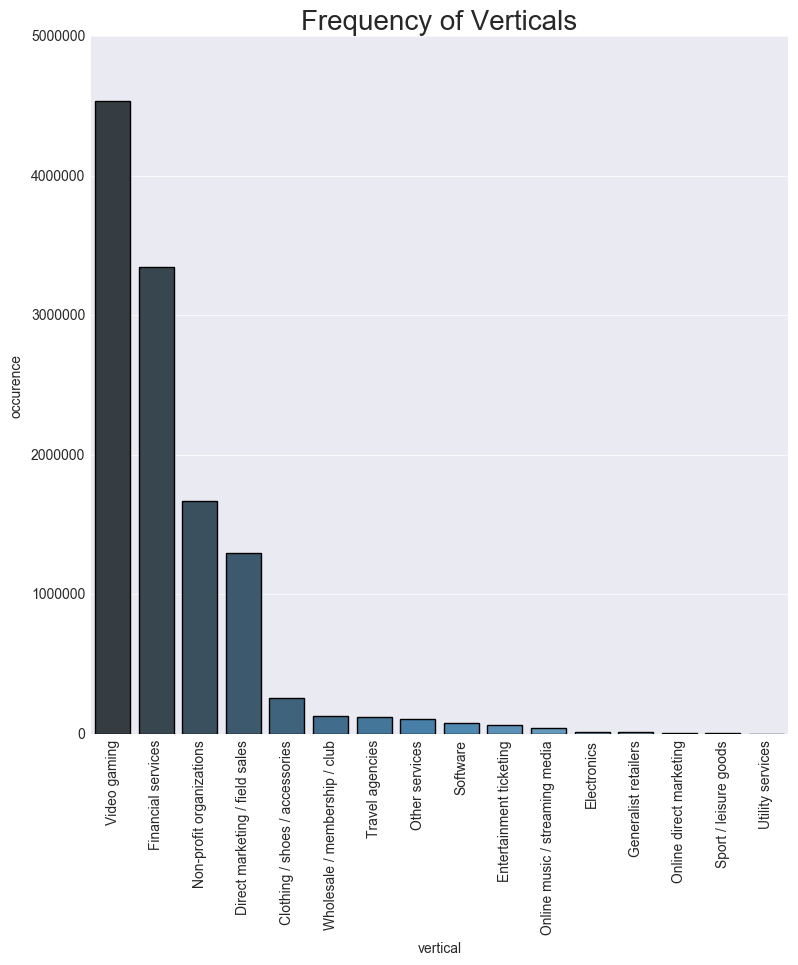

In [82]:
df3_vert=df3_vertical
df3_vert=df3_vert.sum()

df3_vert=pd.DataFrame(df3_vert)
df3_vert=df3_vert.reset_index()

df3_vert=df3_vert.rename(columns={'index':'vertical',0:'occurence'})
df3_vert=df3_vert.sort_values(by='occurence',ascending=False)

sns.set_style("darkgrid")
plt.figure(figsize=(9,9))
plt.xticks(rotation=90)
plt.title('Frequency of Verticals',fontsize=20)
sns.barplot(x="vertical", y="occurence", data=df3_vert, palette="Blues_d")

>## EIRF Feature Frequency

> - Cards that were Consumer, Not interregional (therefore Domestic), and didn't have a Custom Payment Service designation are those most likely to be classified as EIRF;

> - In fact, all three segments have equal numbers and could perhaps be correlated;

> - It does make sense that EIRF is only being charged for 'No Interregional' given that it's a Visa U.S. fee 


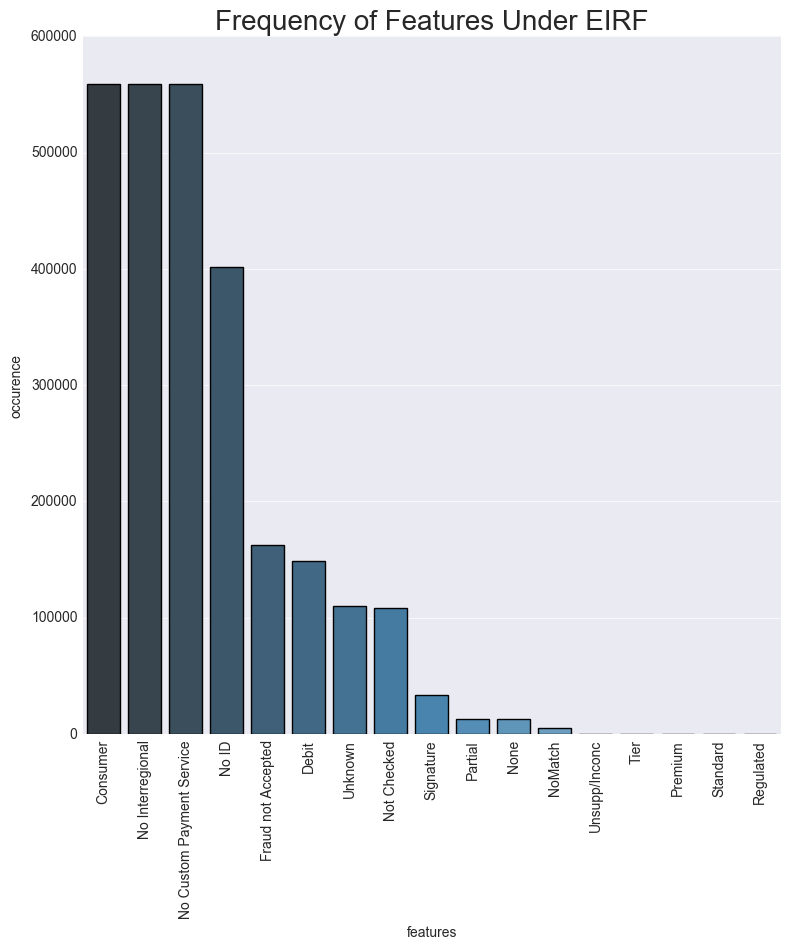

In [83]:
df3_freq=df3[(df3['EIRF_TRANSACTION']==1)].sum()
df3_freq=df3_freq.drop('EIRF_TRANSACTION',axis=0)

df3_freq=pd.DataFrame(df3_freq)
df3_freq=df3_freq.reset_index()

df3_freq=df3_freq.rename(columns={'index':'features',0:'occurence'})
df3_freq=df3_freq.sort_values(by='occurence',ascending=False)

sns.set_style("darkgrid")
plt.figure(figsize=(9,9))
plt.xticks(rotation=90)
plt.title('Frequency of Features Under EIRF',fontsize=20)
sns.barplot(x="features", y="occurence", data=df3_freq, palette="Blues_d")

> ## Generate a heatmap of all of the features in the dataset

>EIRF correlations appear to be around transactions that are regulated, debit, <br> and where there was no custom payment service (perason correlation coefficient = .53)

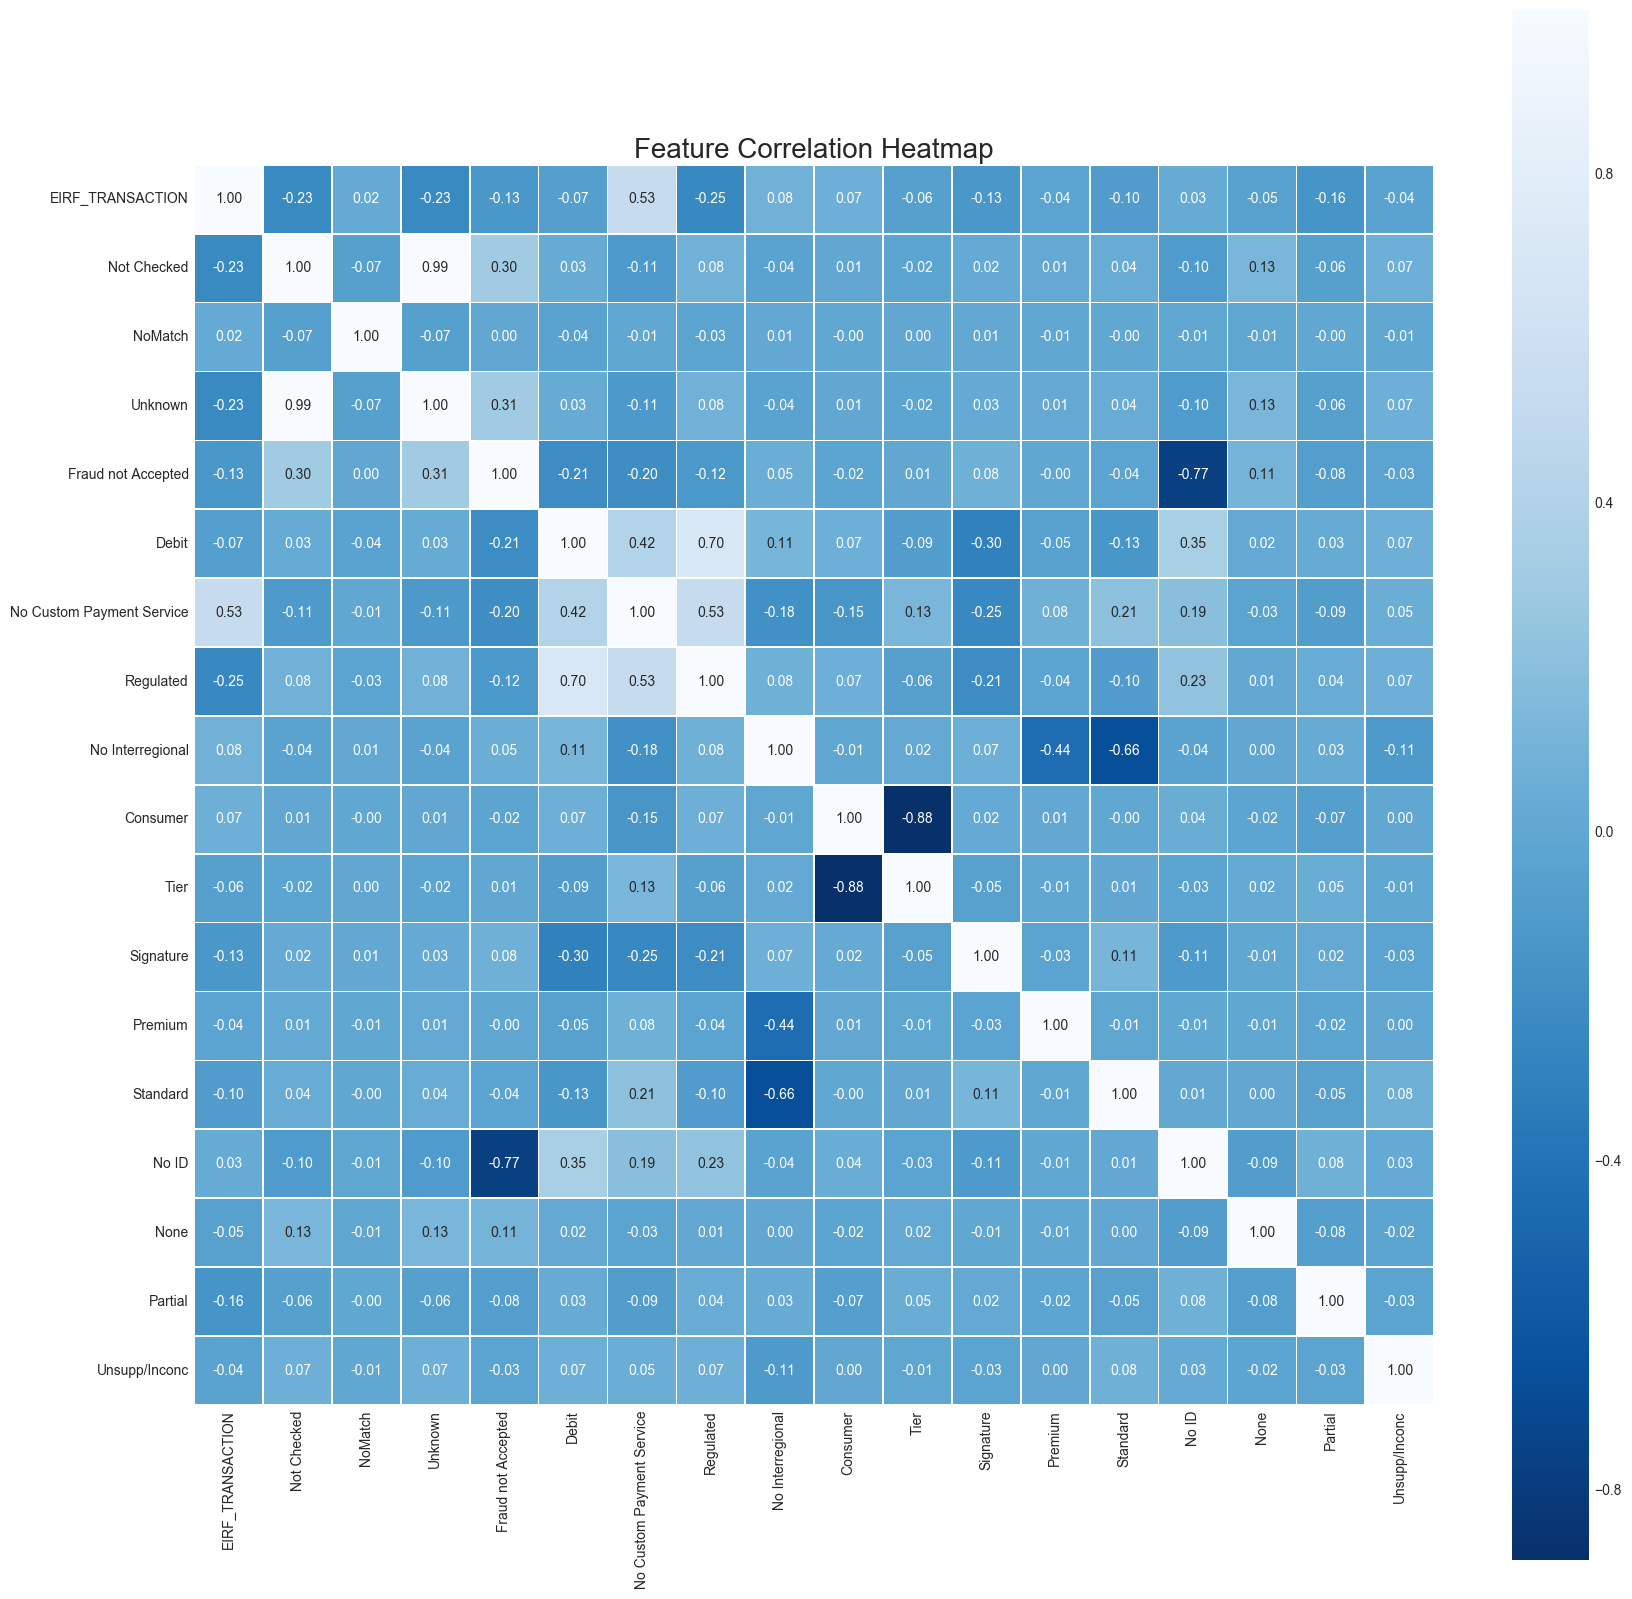

In [172]:
df3_corr=df3.corr().fillna(0)

#[(df3['EIRF_TRANSACTION']==1)]

plt.figure(figsize=(20,20))
plt.title('Feature Correlation Heatmap',fontsize=20)
sns.heatmap(data=df3_corr, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r')

>## Down sampling
>The total dataset contains over 17M line item when measuring the baseline we found that the baseline information was skewed. <br> Therefore taking a smaller smaple of the dataset is set to be in order. A random sample should still be representative of the entire dataset.

In [153]:
df3=df3.sample(frac=0.65, replace=False) #The dataset is rather significant want to apply a random sample of the information rather to prevent 
len(df3)

7605755

> ## Data Exploration: Data split

>- Split between 'EIRF' and No 'EIRF' is 4% to 96% respectively;

>- The split may put more weight on 'No EIRF;'

>- It was suggested that the data be downsampled to make the split more understandable to the models (i.e. 20% 'EIRF' to 80% no 'EIRF')

In [154]:
accuracy=df3.groupby('EIRF_TRANSACTION')[['EIRF_TRANSACTION']].count()
accuracy['EIRF_TRANSACTION_%']=accuracy['EIRF_TRANSACTION']/accuracy['EIRF_TRANSACTION'].sum()
print accuracy

                  EIRF_TRANSACTION  EIRF_TRANSACTION_%
EIRF_TRANSACTION                                      
0                          7242721            0.952269
1                           363034            0.047731


> ## Reduce the Number of Zeros in Effort to Allow more Accurate Weighting of Positive EIRF

>- In our dataset EIRF=1 = 167663 this number is 30%
>- This means that the EIRF=0 share = 391113 or 70%

In [155]:
df3_zero=df3[df3.EIRF_TRANSACTION==0].sample(n=1452636, replace=True)
df3_one=df3[df3.EIRF_TRANSACTION==1].sample(n=363159, replace=True)

df3=pd.concat([df3_zero,df3_one])

In [156]:
df3=df3.reset_index(drop=True)

## Review the "Down Sampled" EIRF Not EIRF Breakout

In [157]:
accuracy=df3.groupby('EIRF_TRANSACTION')[['EIRF_TRANSACTION']].count()
accuracy['EIRF_TRANSACTION_%']=accuracy['EIRF_TRANSACTION']/accuracy['EIRF_TRANSACTION'].sum()
print accuracy

                  EIRF_TRANSACTION  EIRF_TRANSACTION_%
EIRF_TRANSACTION                                      
0                          1452636                 0.8
1                           363159                 0.2


# Random Forest Classifier 

## Split the data between the Variables and the Target

In [90]:
X=df3.drop(['EIRF_TRANSACTION'],axis=1) #Predictors
y=df3[['EIRF_TRANSACTION']] #Targets

#Setup the y values as an array to feed into the training data
#The ravel function allows one to convert from a stacked list to a horizontal array
y = y.values.ravel()

#use the test train split to use 70% of the total dataset to test the data
trainX,testX,trainY,testY=train_test_split(X,y,train_size=0.70, stratify=y) 
#Update the training information for X into values
trainX=trainX.values
print trainX.shape, testX.shape
print trainY.shape, testY.shape

#reset the index numbers
testX=testX.reset_index(drop=True)

(1271056L, 17L) (544739, 17)
(1271056L,) (544739L,)


In [91]:
rfc=RandomForestClassifier()

## The results of previous hyperparameters, establishing ideal parameters

>## Train the Random Forest Classifier

> <b>Best params:</b>
>-  cv=10 
>-  100 estimators
>- log2 max features
>- Recall scoring

> <b>Results:</b>
>-  0.992872064029


In [92]:
params ={'n_estimators':[100],'max_features':['log2']}
gs = GridSearchCV(
    estimator=rfc,
    cv=10,
    param_grid=params,
    scoring='recall'
    )
fit=gs.fit(trainX,trainY)
print gs.best_score_
print gs.best_params_
print gs.cv_results_

0.992872064029
{'max_features': 'log2', 'n_estimators': 100}
{'rank_test_score': array([1]), 'split6_test_score': array([ 0.99331262]), 'split7_train_score': array([ 0.99300669]), 'split0_train_score': array([ 0.99286679]), 'split2_test_score': array([ 0.99307659]), 'mean_fit_time': array([ 58.379]), 'split3_train_score': array([ 0.99287556]), 'split6_train_score': array([ 0.99290179]), 'split9_test_score': array([ 0.99307659]), 'std_test_score': array([ 0.00038373]), 'params': ({'max_features': 'log2', 'n_estimators': 100},), 'split8_test_score': array([ 0.9922505]), 'std_score_time': array([ 0.15633501]), 'std_fit_time': array([ 4.56259112]), 'std_train_score': array([  4.85570679e-05]), 'split4_test_score': array([ 0.99335195]), 'split1_train_score': array([ 0.99290616]), 'split2_train_score': array([ 0.99282748]), 'param_n_estimators': masked_array(data = [100],
             mask = [False],
       fill_value = ?)
, 'split4_train_score': array([ 0.99290179]), 'mean_score_time': arra

## Precision/Recall Classification Report

In [93]:
print classification_report(testY, gs.predict(testX), )

             precision    recall  f1-score   support

          0       1.00      0.99      0.99    435791
          1       0.96      0.99      0.98    108948

avg / total       0.99      0.99      0.99    544739



## Precision/Recall Curve

(0.0, 1.0)

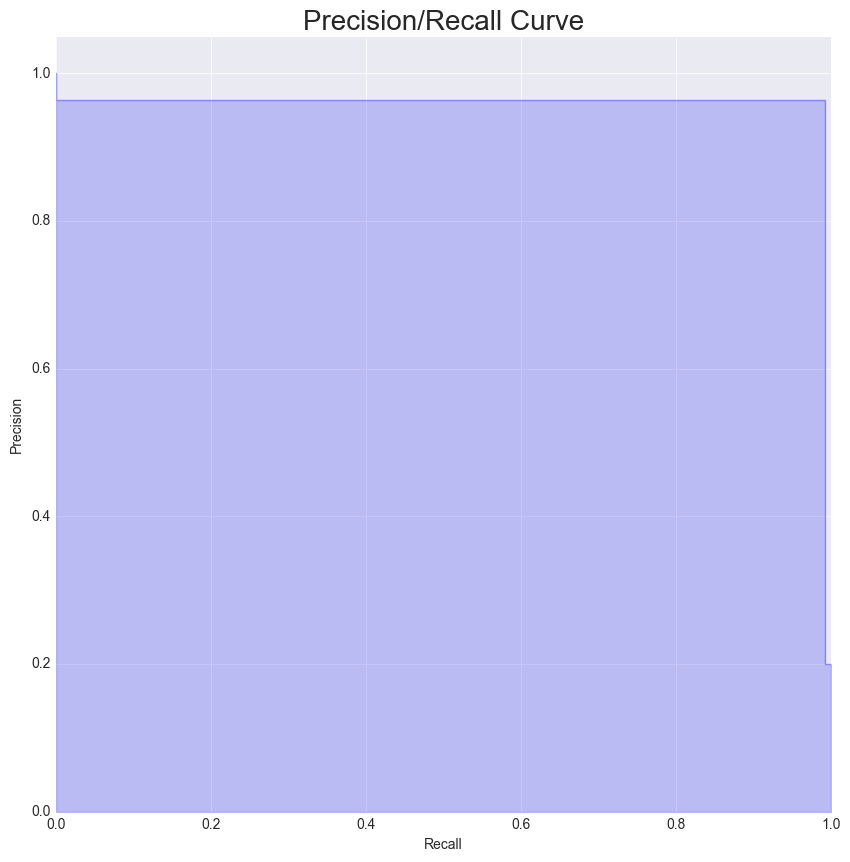

In [94]:
actual=pd.DataFrame(testY,columns={'actual'})
prediction=pd.DataFrame(gs.predict(testX),columns={'prediction'})

sns.set_style("darkgrid")
plt.figure(figsize=(10,10))

precision, recall, thresholds = precision_recall_curve(actual, prediction)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve',fontsize=20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

## Feature Importances


In [95]:
importance=pd.DataFrame(gs.best_estimator_.feature_importances_,columns={'Importance'})
features=pd.DataFrame(X.columns,columns={'Features'})
feature_importance=features.join(importance).sort_values(by='Importance',ascending=False)
print feature_importance

                     Features  Importance
5   No Custom Payment Service    0.425247
6                   Regulated    0.214986
12                   Standard    0.059623
8                    Consumer    0.038672
4                       Debit    0.038456
2                     Unknown    0.033600
7            No Interregional    0.030906
10                  Signature    0.030060
15                    Partial    0.027483
13                      No ID    0.027279
0                 Not Checked    0.027236
3          Fraud not Accepted    0.021441
9                        Tier    0.016224
11                    Premium    0.006257
14                       None    0.001896
16              Unsupp/Inconc    0.000559
1                     NoMatch    0.000074


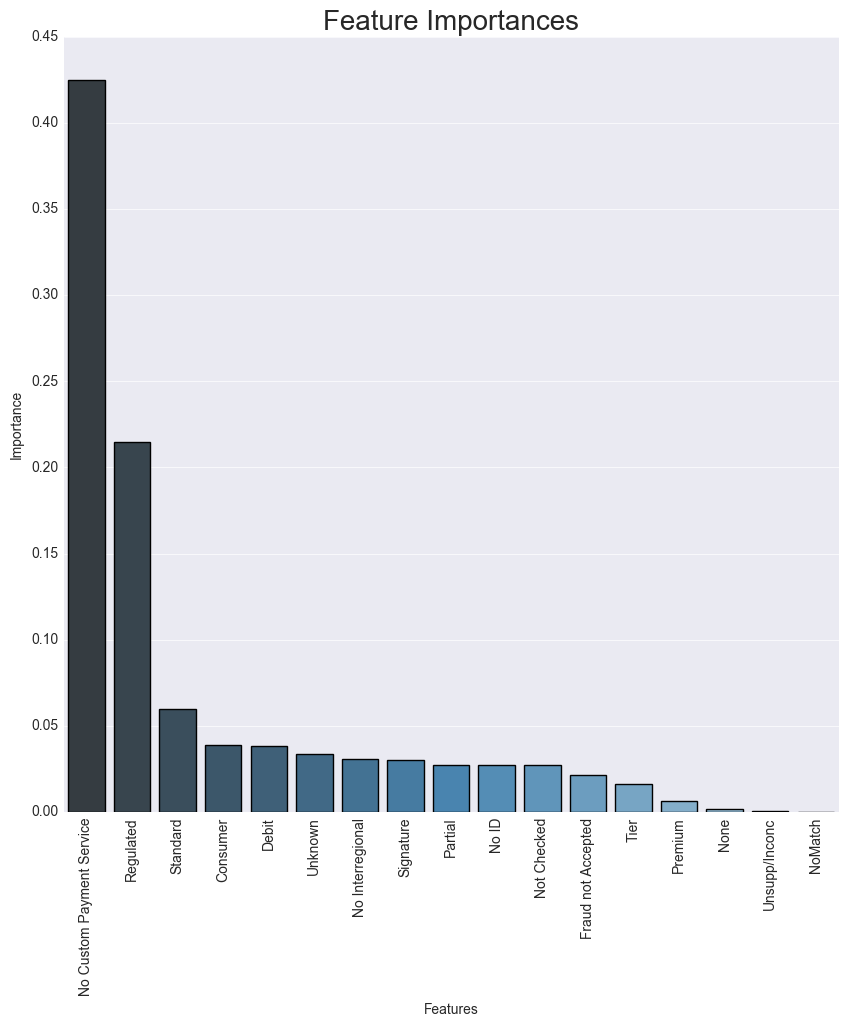

In [96]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.title('Feature Importances',fontsize=20)
x=sns.barplot(x="Features", y="Importance",data=feature_importance, palette="Blues_d")

## ROC AUC Score (Curve)

0.991668032639


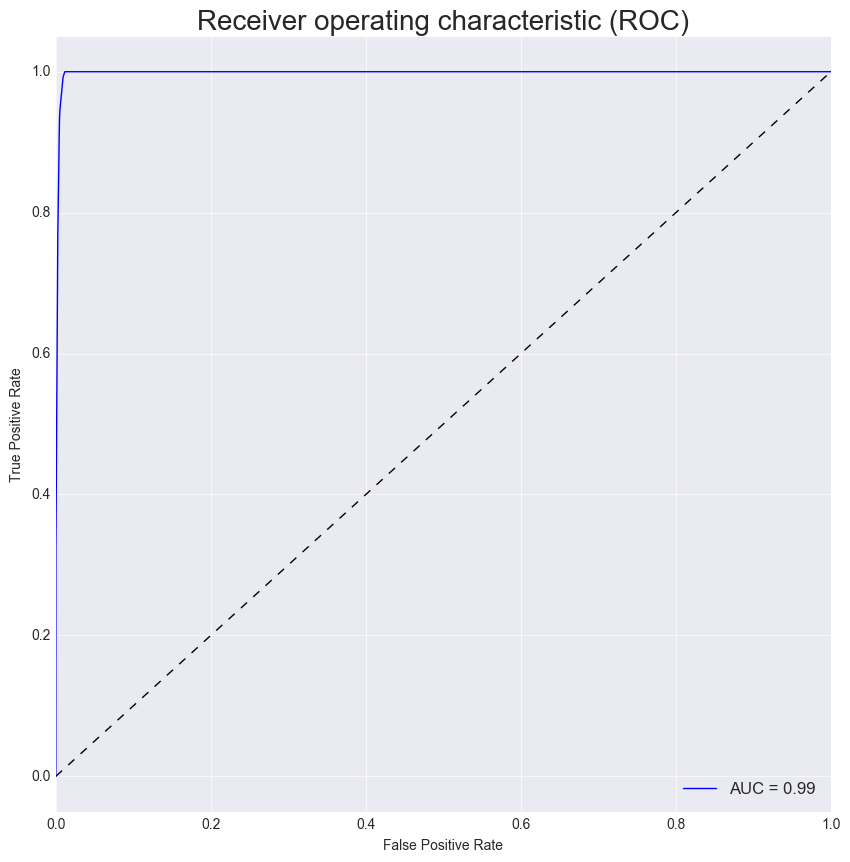

In [97]:
probas =gs.predict_proba(testX)
roc_auc=roc_auc_score(actual, prediction)
print roc_auc

sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plt.plot(roc_curve(testY, probas[:,1])[0], roc_curve(testY, probas[:,1])[1],'b',label='AUC = %0.2f'% roc_auc)
#plt.plot(roc_curve(testY, probas[:,1])[0], roc_curve(testY, probas[:,1])[1],'b')

plt.plot([0, 1], [0, 1], 'k--',) #This plots the 50/50 odds, this line determines if a classifier is good, random (50% mark), or a failure
plt.ylim([-0.05, 1.05]) #this sets the limit to the chart size

#add in the labeling information
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)',fontsize=20)
plt.legend(loc='lower right')

plt.figure(figsize=(1,1))

## Confusion Matrix Crosstab

In [98]:
actual_prediction=actual.join(prediction)

y_true=actual_prediction['actual']
y_pred=actual_prediction['prediction']

cmct=pd.crosstab(y_true, y_pred,rownames=['True'],colnames=['Predicted'],margins=False)
print cmct

Predicted       0       1
True                     
0          431677    4114
1             787  108161


## Plot the Confustion Matrix

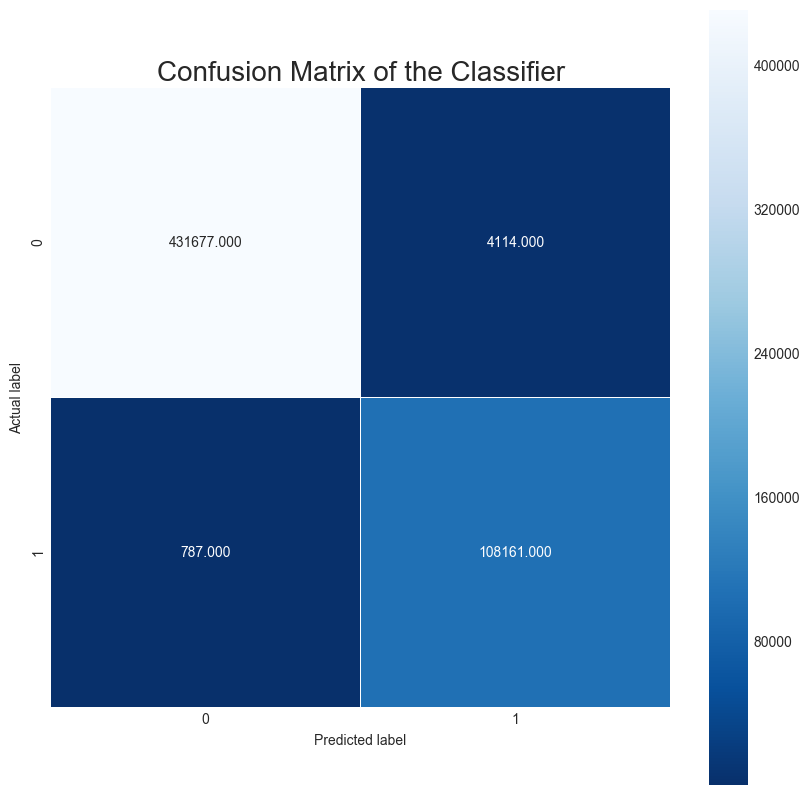

In [99]:
cm=confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix of the Classifier',fontsize=20)

>## Data Analysis: Random Forest Classifier

>- All results are excellent, roc auc score =.99
>- Too good to be true? 
>- Perhaps Logistic Regression will be more telling?


# Logistic Regression

>## Train the Random Forest Classifier

> <b>Best params:</b>
>-  cv=10 
>-  penalty =l2
>- Recall scoring

> <b>Results:</b>
>-  0.996868741211


In [100]:
lr=LogisticRegression()

In [101]:
params = {'penalty':['l1','l2']} # put your gradient descent parameters here
lrgs = GridSearchCV(
    estimator=lr,
    cv=10,
    param_grid=params,
    scoring='recall'
    )
lrgs.fit(trainX,trainY)
print lrgs.best_score_
print lrgs.best_params_ 

0.996868741211
{'penalty': 'l1'}


In [102]:
print lrgs.cv_results_

{'rank_test_score': array([1, 1]), 'split6_test_score': array([ 0.99720703,  0.99720703]), 'split7_train_score': array([ 0.99684427,  0.99684427]), 'split0_train_score': array([ 0.99682677,  0.99682677]), 'split2_test_score': array([ 0.99689233,  0.99689233]), 'mean_fit_time': array([ 111.48609996,    6.04740002]), 'split3_train_score': array([ 0.99693605,  0.99694043]), 'param_penalty': masked_array(data = ['l1' 'l2'],
             mask = [False False],
       fill_value = ?)
, 'split6_train_score': array([ 0.99683116,  0.99683116]), 'split9_test_score': array([ 0.99708902,  0.99708902]), 'std_test_score': array([ 0.00032782,  0.00032782]), 'params': ({'penalty': 'l1'}, {'penalty': 'l2'}), 'split8_test_score': array([ 0.99708902,  0.99708902]), 'std_score_time': array([ 0.00294108,  0.0042379 ]), 'std_fit_time': array([ 6.98784179,  0.16888468]), 'std_train_score': array([  3.64239358e-05,   3.72459960e-05]), 'split4_test_score': array([ 0.996853,  0.996853]), 'split1_train_score': ar

## Precision/Recall Classification Report

In [103]:
print classification_report(testY, lrgs.predict(testX), )

             precision    recall  f1-score   support

          0       1.00      0.99      0.99    435791
          1       0.95      1.00      0.97    108948

avg / total       0.99      0.99      0.99    544739



## Precision/Recall Curve

(0.0, 1.0)

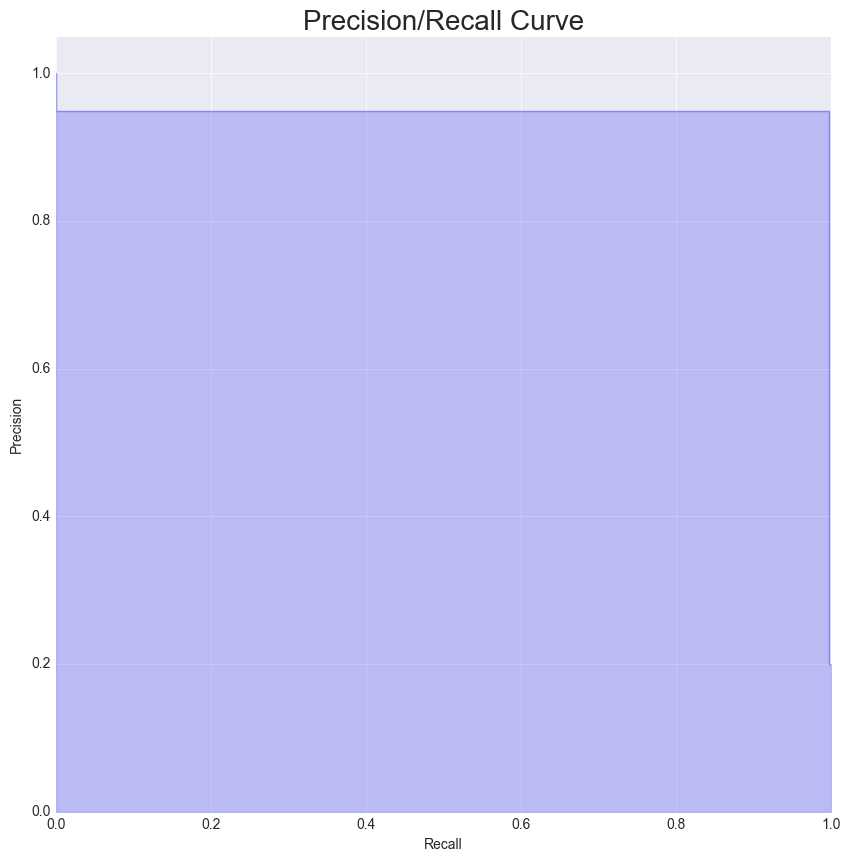

In [104]:
actual=pd.DataFrame(testY,columns={'actual'})
prediction=pd.DataFrame(lrgs.predict(testX),columns={'prediction'})

sns.set_style("darkgrid")
plt.figure(figsize=(10,10))

precision, recall, thresholds = precision_recall_curve(actual, prediction)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve',fontsize=20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

## Identify the Coefficients, Showing the Log Odds of each Feature

In [105]:
lrgs.best_estimator_.coef_ #use equation to convert log odds to probaility - these are odd for every unit increase in x the coeffecient increases by the below amounts
                         #those cases where we see a negative the likelihood of that feature resulting in EIRF is less whereas positive coefficients have a positive effect on the likelihood of EIRF

array([[  3.28098799,   0.62627503,  -2.72670679,  -0.5092887 ,
          2.623196  ,  15.77101822, -18.02003391,   2.92336285,
         10.44952539,  -1.84042404,   4.2855505 ,  -8.88911958,
        -16.8023081 ,   0.52366007,  -0.4734031 ,  -2.1537849 ,
         -3.04680716]])

In [106]:
coef=lrgs.best_estimator_.coef_
coef=pd.DataFrame(coef).unstack().reset_index(drop=True)
coef=pd.DataFrame(coef)
coef=coef.rename(columns={0:'coefs'})

features=pd.DataFrame(X.columns,columns={'features'})

coef_plot=features.join(coef).sort_values(by='coefs',ascending=False)
print coef_plot

                     features      coefs
5   No Custom Payment Service  15.771018
8                    Consumer  10.449525
10                  Signature   4.285551
0                 Not Checked   3.280988
7            No Interregional   2.923363
4                       Debit   2.623196
1                     NoMatch   0.626275
13                      No ID   0.523660
14                       None  -0.473403
3          Fraud not Accepted  -0.509289
9                        Tier  -1.840424
15                    Partial  -2.153785
2                     Unknown  -2.726707
16              Unsupp/Inconc  -3.046807
11                    Premium  -8.889120
12                   Standard -16.802308
6                   Regulated -18.020034


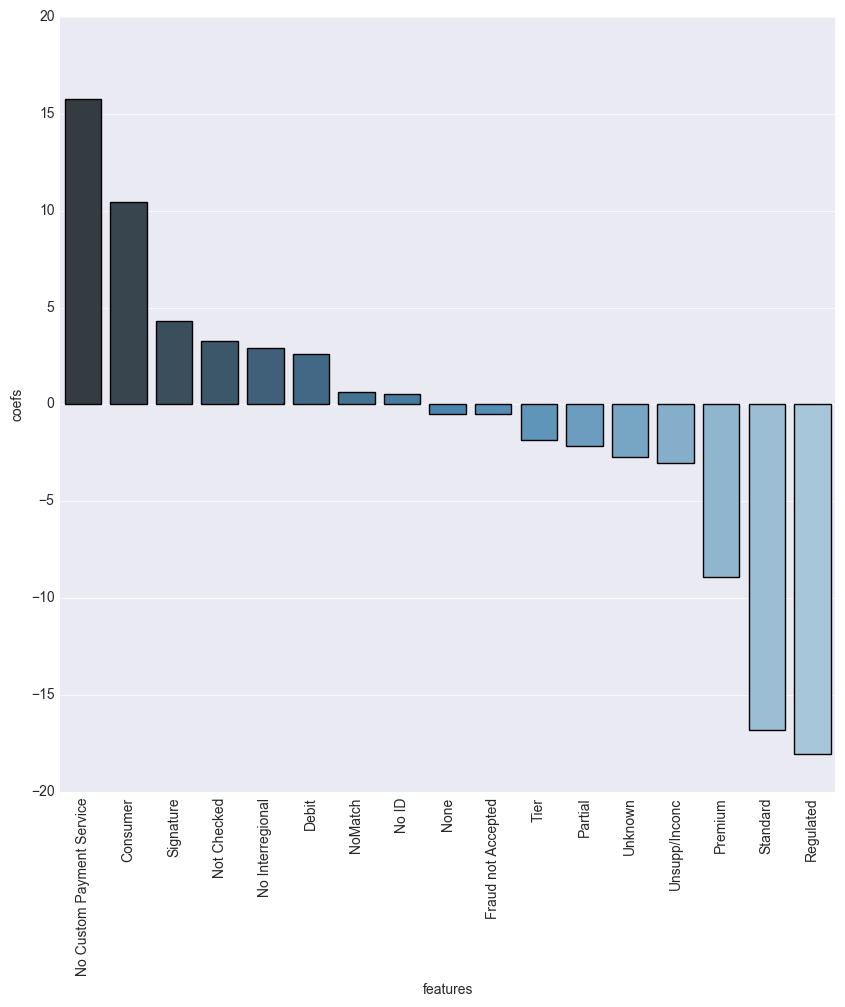

In [107]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
x=sns.barplot(x="features", y="coefs", data=coef_plot, palette="Blues_d")

## ROC AUC Score (Curve)

0.99187340125


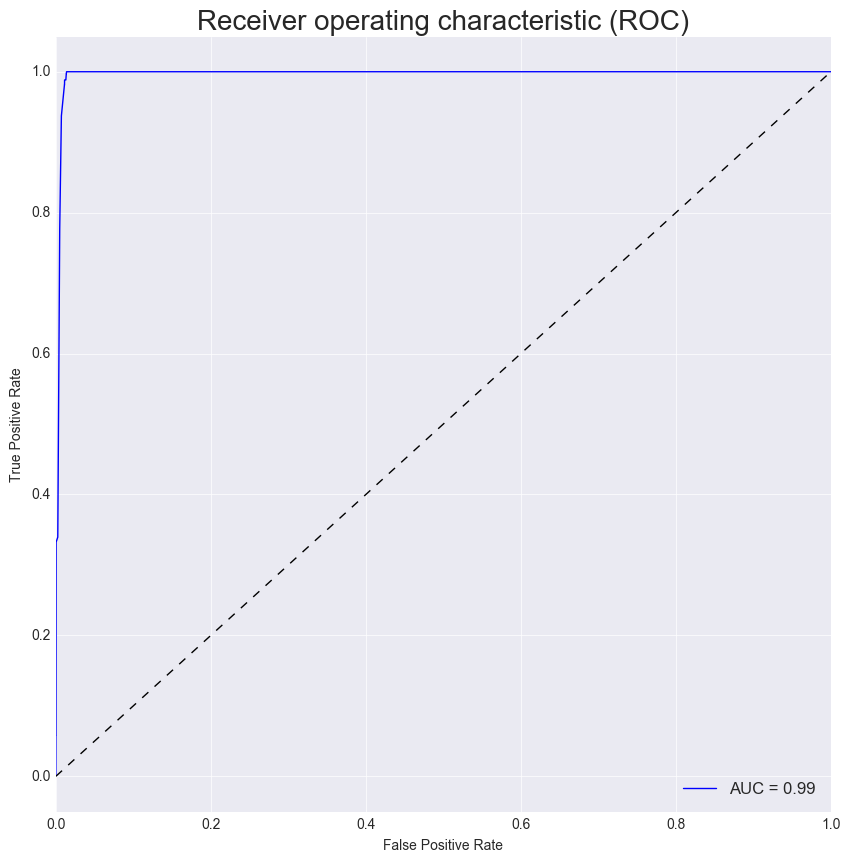

In [108]:
probas =lrgs.predict_proba(testX)
roc_auc=roc_auc_score(actual, prediction)
print roc_auc

sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plt.plot(roc_curve(testY, probas[:,1])[0], roc_curve(testY, probas[:,1])[1],'b',label='AUC = %0.2f'% roc_auc)
#plt.plot(roc_curve(testY, probas[:,1])[0], roc_curve(testY, probas[:,1])[1],'b')

plt.plot([0, 1], [0, 1], 'k--',) #This plots the 50/50 odds, this line determines if a classifier is good, random (50% mark), or a failure
plt.ylim([-0.05, 1.05]) #this sets the limit to the chart size

#add in the labeling information
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)',fontsize=20)
plt.legend(loc='lower right')

plt.figure(figsize=(1,1))

## Confusion Matrix Crosstab

In [109]:
actual_prediction=actual.join(prediction)

y_true=actual_prediction['actual']
y_pred=actual_prediction['prediction']

cmct=pd.crosstab(y_true, y_pred,rownames=['True'],colnames=['Predicted'],margins=False)
print cmct

Predicted       0       1
True                     
0          429932    5859
1             306  108642


## Plot the Confustion Matrix

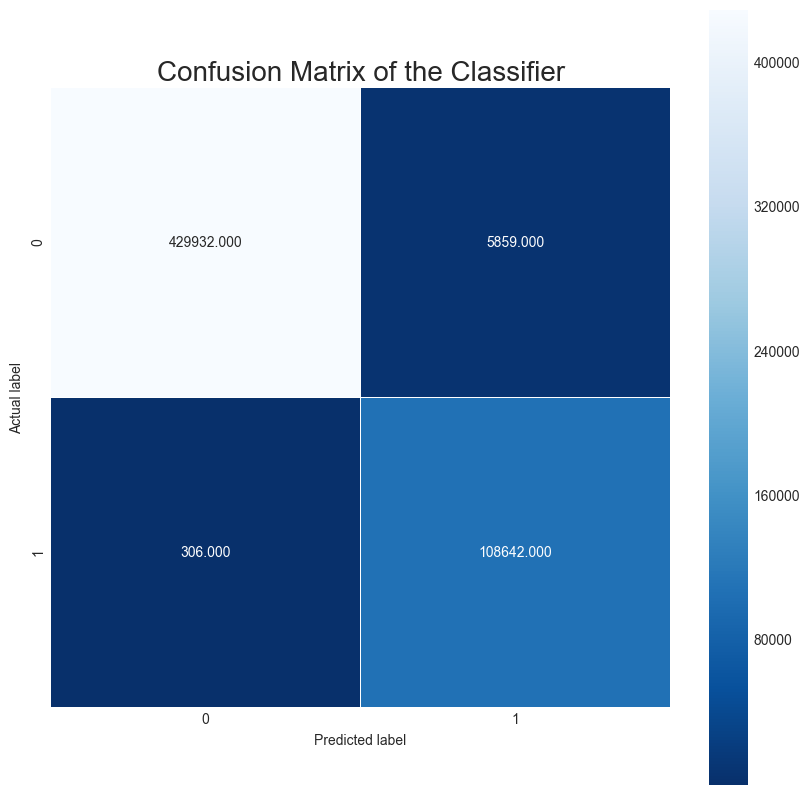

In [110]:
cm=confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix of the Classifier',fontsize=20)

># Data Analysis: Results

>- Both models appear to prioritize many of the same features particularly "No Customer Payment Service"
>- The random forest model shows what features it identified as most important to make its predictions
>- Similarly the logistic regression shows which features drove the odds of a transaction being EIRF or not EIRF
>- The excellent results and domiance beg the question is "No Customer Payment Service" a biased estimator? Probably Not.

># Conclusions

>- Using random forest and logistic regression I was able to build a model based on the cost information from one acquring bank that can be potentially be used across the organization's entirely portfolio to predict downgraded EIRF transactions to identify offending merchants and encourage these merchants to change their transaction processing behavier. The Recall and Roc AUC for both models were +.90.

>- The information from the analsysis identifies those features that are most correlated and uses a model on thise feature to classify EIRF against a transactional dataset.

>- The logistic regression appears to be the most suitable model from a scoring and explantion standpoint. It can be shared with leadership from the logistics regression that the most likely scenario for an EIRF to occur is when a transaction is not identified as "No Custom Payment Service" is a "Consumer," "Signature" card where CVV has not been checked.

># Next Steps

>- Potential next steps are to explore the "No Custom Payment Service" more in-depth. Understading this feature and maybe predicting it as well can give a glimpse at a more granular level of what additional features may be contributing to EIRF. Based on definitions from online sources, the biggest cause of "No Custom Payment Service" is No Address Verification System data being provided but there are other reasons that are not explicitly identified, This is why building such a model would be ideal.

> source: https://dharmamerchantservices.com/faq/visa-card-not-present-cps/

In [132]:
df3_conclu=df3[(df3['No Custom Payment Service']==1)].groupby('EIRF_TRANSACTION').sum()
df3_conclu

,Not Checked,NoMatch,Unknown,Fraud not Accepted,Debit,No Custom Payment Service,Regulated,No Interregional,Consumer,Tier,Signature,Premium,Standard,No ID,None,Partial,Unsupp/Inconc
EIRF_TRANSACTION,,,,,,,,,,,,,,,,,
0,239812.0,1205.0,240583.0,155371.0,361032.0,484387.0,357053.0,434930.0,450948.0,26267.0,26931.0,9604.0,65312.0,401689.0,23963.0,71479.0,9135.0
1,69526.0,3410.0,70499.0,104669.0,96920.0,363159.0,0.0,363159.0,363159.0,0.0,21725.0,0.0,0.0,261763.0,8234.0,8557.0,10.0


## Perhaps the Results from the Dataset are too Perfect and therefore Biased, Let's Rerun the Random Forest Without "No Custom Payment Service	" and with Indsutry Segments added in

In [159]:
X=df3.drop(['EIRF_TRANSACTION','No Custom Payment Service'],axis=1) #Predictors
y=df3[['EIRF_TRANSACTION']] #Targets

#Setup the y values as an array to feed into the training data
#The ravel function allows one to convert from a stacked list to a horizontal array
y = y.values.ravel()

#use the test train split to use 70% of the total dataset to test the data
trainX,testX,trainY,testY=train_test_split(X,y,train_size=0.70, stratify=y) 
#Update the training information for X into values
trainX=trainX.values
print trainX.shape, testX.shape
print trainY.shape, testY.shape

#reset the index numbers
testX=testX.reset_index(drop=True)

(1271056L, 32L) (544739, 32)
(1271056L,) (544739L,)


## Train the Random Forest Classifier

In [160]:
rfc=RandomForestClassifier()

In [161]:
params ={'n_estimators':[100],'max_features':['log2']}
gs = GridSearchCV(
    estimator=rfc,
    cv=10,
    param_grid=params,
    scoring='recall'
    )
fit=gs.fit(trainX,trainY)
print gs.best_score_
print gs.best_params_
print gs.cv_results_

0.978891549684
{'max_features': 'log2', 'n_estimators': 100}
{'rank_test_score': array([1]), 'split6_test_score': array([ 0.97856103]), 'split7_train_score': array([ 0.97874907]), 'split0_train_score': array([ 0.97896752]), 'split2_test_score': array([ 0.97919043]), 'mean_fit_time': array([ 105.29030001]), 'split3_train_score': array([ 0.97902443]), 'split6_train_score': array([ 0.97900695]), 'split9_test_score': array([ 0.97907242]), 'std_test_score': array([ 0.00086726]), 'params': ({'max_features': 'log2', 'n_estimators': 100},), 'split8_test_score': array([ 0.97871838]), 'std_score_time': array([ 0.13625523]), 'std_fit_time': array([ 2.9382464]), 'std_train_score': array([  9.36257614e-05]), 'split4_test_score': array([ 0.97808898]), 'split1_train_score': array([ 0.97903755]), 'split2_train_score': array([ 0.9789239]), 'param_n_estimators': masked_array(data = [100],
             mask = [False],
       fill_value = ?)
, 'split4_train_score': array([ 0.97884523]), 'mean_score_time':

## Precision/Recall Classification Report

In [162]:
print classification_report(testY, gs.predict(testX), )

             precision    recall  f1-score   support

          0       0.99      0.96      0.97    435791
          1       0.85      0.98      0.91    108948

avg / total       0.96      0.96      0.96    544739



## Precision/Recall Curve

(0.0, 1.0)

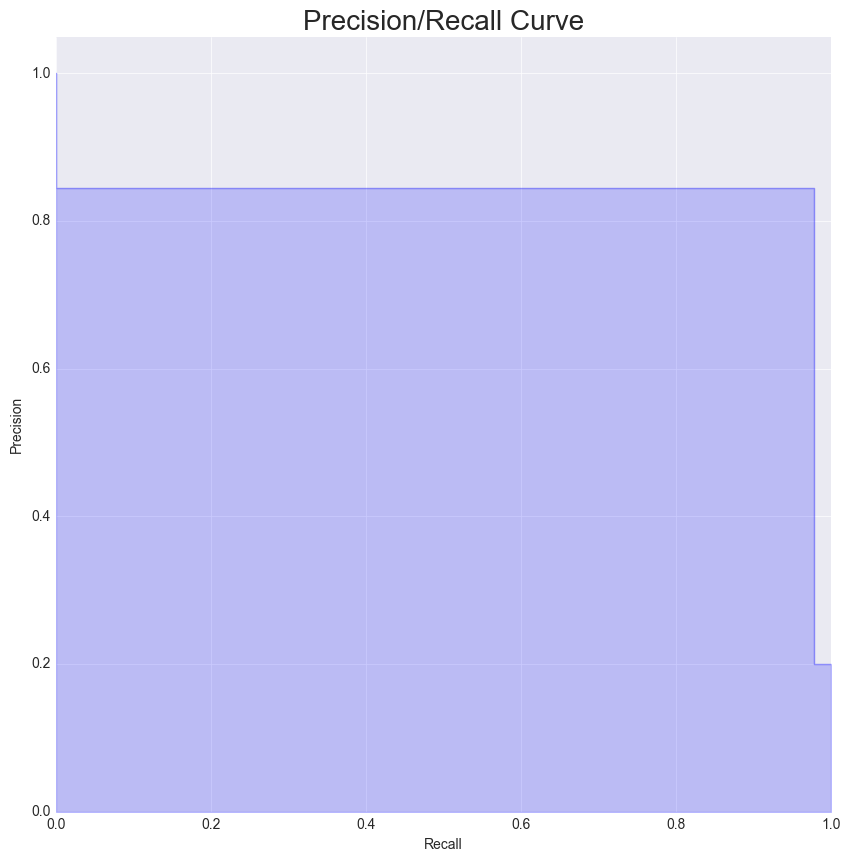

In [163]:
actual=pd.DataFrame(testY,columns={'actual'})
prediction=pd.DataFrame(gs.predict(testX),columns={'prediction'})

sns.set_style("darkgrid")
plt.figure(figsize=(10,10))

precision, recall, thresholds = precision_recall_curve(actual, prediction)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve',fontsize=20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

## Feature Importances

In [164]:
importance=pd.DataFrame(gs.best_estimator_.feature_importances_,columns={'Importance'})
features=pd.DataFrame(X.columns,columns={'Features'})
feature_importance=features.join(importance).sort_values(by='Importance',ascending=False)
print feature_importance

                          Features  Importance
18                         Unknown    0.132116
14                    Video gaming    0.130498
21                       Regulated    0.116110
16                     Not Checked    0.115072
4               Financial services    0.090054
12                 Travel agencies    0.075904
25                       Signature    0.063616
19              Fraud not Accepted    0.048961
6         Non-profit organizations    0.033429
1   Direct marketing / field sales    0.031089
27                        Standard    0.029166
28                           No ID    0.029163
30                         Partial    0.027132
22                No Interregional    0.021607
20                           Debit    0.012977
10                        Software    0.012758
0   Clothing / shoes / accessories    0.006316
3          Entertainment ticketing    0.004696
15   Wholesale / membership / club    0.003787
23                        Consumer    0.003517
29           

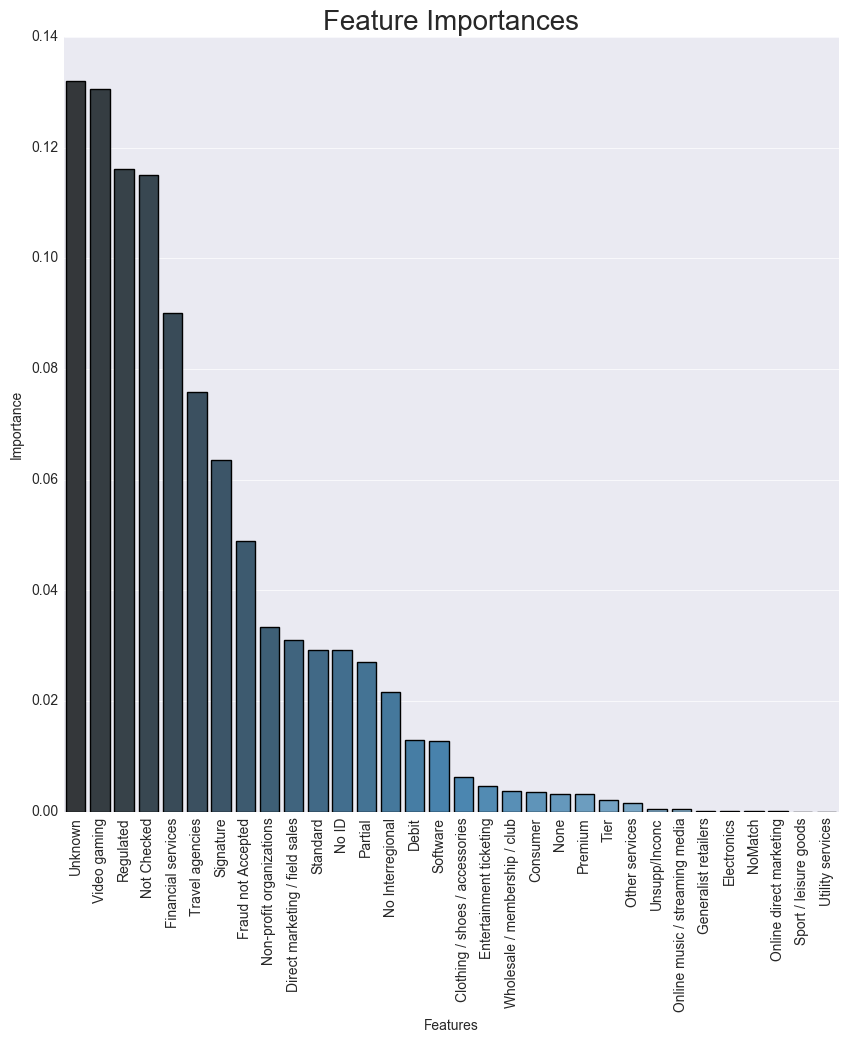

In [165]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.title('Feature Importances',fontsize=20)
x=sns.barplot(x="Features", y="Importance",data=feature_importance, palette="Blues_d")

0.966770793484


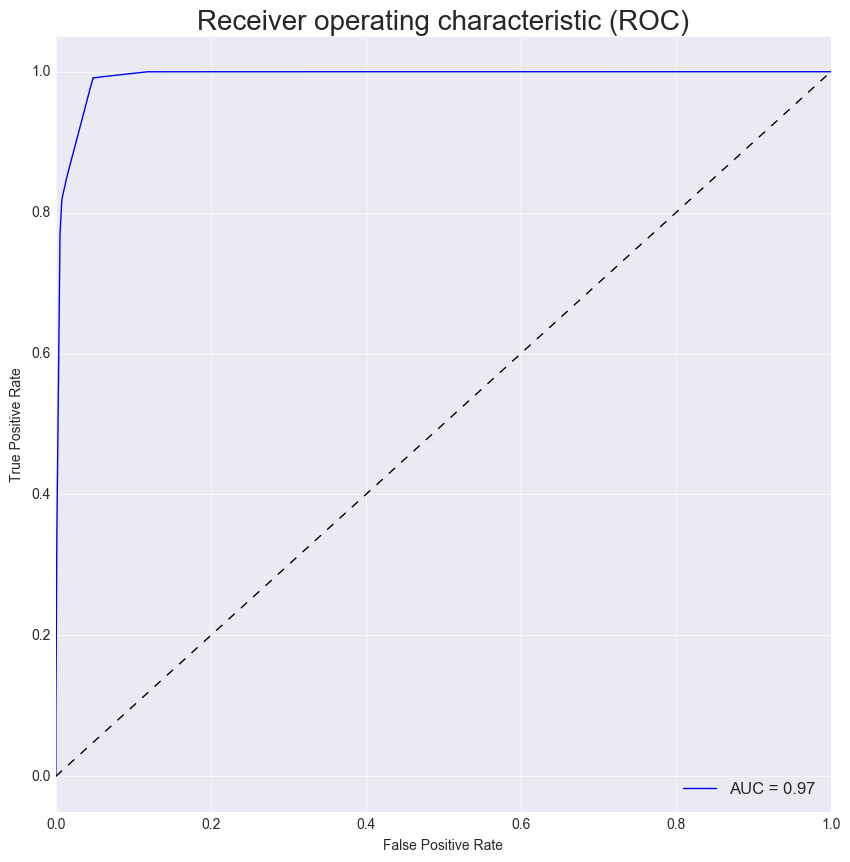

In [166]:
probas =gs.predict_proba(testX)
roc_auc=roc_auc_score(actual, prediction)
print roc_auc

sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plt.plot(roc_curve(testY, probas[:,1])[0], roc_curve(testY, probas[:,1])[1],'b',label='AUC = %0.2f'% roc_auc)
#plt.plot(roc_curve(testY, probas[:,1])[0], roc_curve(testY, probas[:,1])[1],'b')

plt.plot([0, 1], [0, 1], 'k--',) #This plots the 50/50 odds, this line determines if a classifier is good, random (50% mark), or a failure
plt.ylim([-0.05, 1.05]) #this sets the limit to the chart size

#add in the labeling information
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)',fontsize=20)
plt.legend(loc='lower right')

plt.figure(figsize=(1,1))